# Analysis of Marathon Results
### May 14, 2023

# Introduction

Welcome to another and final amazing project that dives into the Bayes classifier, the kNN predictor and, the regression model predictions ability to determine what sex the time of a marathon runner was based off the other 26,298 runners. In this project, the set of data that the Bayes classifer, kNN and regression predictor will be working with are one that is 26,298 runners that have age, sex, splits and other categories associated with them. 

The Bayes Theorem looks like $$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$$ and for those of you who haven't taken a probability course, the theorem finds that likelihood of A happening given that B has also occurred. A simple example in this project would be the probability that a runner is a male given a finishing time.

The Bayes classifer in this project works my taking in a finishing time in minutes. Then, gets the bayes probability that that time came from a male or a female and compares them. The higher probability of the two is what the predection will be. 

The kNN classifier works in a different way. It is given the time and looks at it as a datapoint. It then takes the 'k' nearest neighbors which can be any number that you choose. From these neighbors, it takes the mode of the neighbors and returns 1 prediction. For example, if a runner in the middle of the pack is surrounded by women, it will predict that that runner is also a woman. 

Finally, the regression model works by calculating the y intercept and best fit slope of all of the data points. It then uses this best fit line to return predictions back to the user. If you wanted to predict someones final time based off of their first mile, this model would look at the best fit line and then you could see what the computer thinks your final time would be.

### Import Python libraries

In [17]:
import json
import pandas as pd
from scipy import stats
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression

### Importing the marathon data from a csv file to be analyzed

In [18]:
df = pd.read_csv("marathon_results.csv")
df.head()

,Age,M/F,Country,5K,10K,15K,20K,Half,25K,30K,35K,40K,Finish,Pace,Overall,Gender,Division
0,25,M,ETH,00:14:43,00:29:43,00:44:57,01:00:29,01:04:02,01:16:07,01:32:00,01:47:59,02:02:39,02:09:17,00:04:56,1,1,1
1,30,M,ETH,00:14:43,00:29:43,00:44:58,01:00:28,01:04:01,01:16:07,01:31:59,01:47:59,02:02:42,02:09:48,00:04:58,2,2,2
2,29,M,KEN,00:14:43,00:29:43,00:44:57,01:00:29,01:04:02,01:16:07,01:32:00,01:47:59,02:03:01,02:10:22,00:04:59,3,3,3
3,28,M,KEN,00:14:43,00:29:44,00:45:01,01:00:29,01:04:02,01:16:07,01:32:00,01:48:03,02:03:47,02:10:47,00:05:00,4,4,4
4,32,M,KEN,00:14:43,00:29:44,00:44:58,01:00:28,01:04:01,01:16:07,01:32:00,01:47:59,02:03:27,02:10:49,00:05:00,5,5,5


In [19]:
# adding the 'tot_minutes' column to be used for calcualtions as all of the times are strings 
df['tot_minutes'] = pd.to_timedelta(df['Finish']).dt.total_seconds()/60

In [20]:
# creating dataframe of males for percentage
df_male = df[df['M/F']=='M']

In [21]:
# creating dataframe of females for percentage
df_female = df[df['M/F']=='F']

In [22]:
train_df = pd.read_csv("marathon_results.csv")

train_df,test_df = train_test_split(train_df,test_size=0.5,random_state=123)

train_df['tot_minutes'] = pd.to_timedelta(train_df['Finish']).dt.total_seconds()/60
train_df['5K_minutes'] = pd.to_timedelta(train_df['5K']).dt.total_seconds()/60

train_df_male = train_df[train_df['M/F']=='M']
train_df_female = train_df[train_df['M/F']=='F']

kde_whole = stats.gaussian_kde(train_df['tot_minutes']) 

kde_male = stats.gaussian_kde(train_df_male['tot_minutes'])    
kde_female = stats.gaussian_kde(train_df_female['tot_minutes'])

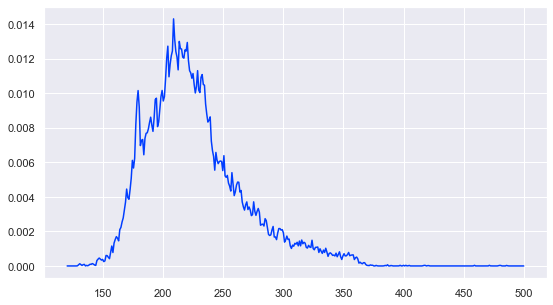

In [23]:
kde = gaussian_kde(df['tot_minutes'],bw_method=.01)

plt.figure(figsize=(9, 5))
sns.set_theme(style="darkgrid", palette="bright")
x = np.linspace(120,500,400)
plt.plot(x, kde(x));

The graph above is showing what percent of runners came from each of the times between 120 and 500 minutes in 400 intervals. Here you can see that most of the runners finished in that time between 200 and 240ish minutes. This is the interval where wrong classifications will occur because there is more conflicting data.

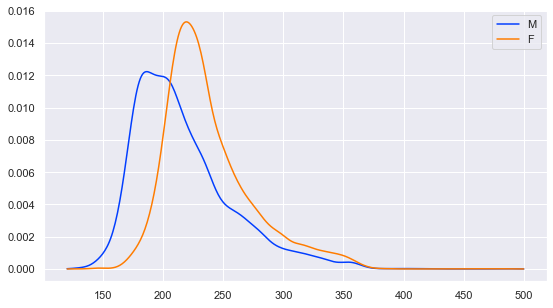

In [24]:
plt.figure(figsize=(9, 5))
x = np.linspace(120,500,400)
plt.plot(x, kde_male(x),label='M')
plt.plot(x, kde_female(x),label='F')
plt.legend();

This graph is the same except now you can see the percentages split up amongst men and women. Here, when the lines are close together is when it will specifically predict the runners wrong more frequently. In the beginning more of the runners are male so it will have an easier time here and also towards the end most of the runners are female. In the middle, where the two lines cross is where it is basically a 50/50 whether that runner is a male or a female

# Part 1: 1-dimensional kernel density estimate

In [25]:
train_df = pd.read_csv("marathon_results.csv")

train_df,test_df = train_test_split(train_df,test_size=0.5,random_state=123)

train_df['tot_minutes'] = pd.to_timedelta(train_df['Finish']).dt.total_seconds()/60
train_df['5K_minutes'] = pd.to_timedelta(train_df['5K']).dt.total_seconds()/60

train_df_male = train_df[train_df['M/F']=='M']
train_df_female = train_df[train_df['M/F']=='F']

kde_whole = stats.gaussian_kde(train_df['tot_minutes']) 

kde_male = stats.gaussian_kde(train_df_male['tot_minutes'])    
kde_female = stats.gaussian_kde(train_df_female['tot_minutes'])


male_p = len(train_df_male)/len(train_df)
female_p = len(train_df_female)/len(train_df)

In [26]:
def bayes_from_time(x):
    mp = (male_p*kde_male(x))/kde_whole(x)
    fp = (female_p*kde_female(x))/kde_whole(x)
    if mp[0] > fp[0]:
        return 'M'
    else: 
        return 'F'

In [27]:
num = 0
den = len(train_df) 
for i in tqdm(range(den)):
    if bayes_from_time(train_df.iloc[i,17]) == train_df.iloc[i,1]:
        num += 1
print(num/den)

100%|██████████████████████████████████████████████████████████████████████████| 13149/13149 [00:12<00:00, 1085.21it/s]

0.6535097726062818


Here the bayes classifer had a accuracy of around 65%. Many of those incorrect calls must have come from the times where many men and women were finishing at the same time.

# Part 2: 2-dimensional kernel density estimate

In [28]:
kde_whole_age = stats.gaussian_kde([train_df['tot_minutes'],train_df['Age']]) 

kde_male_age = stats.gaussian_kde([train_df['tot_minutes'],train_df['Age']])    
kde_female_age = stats.gaussian_kde([train_df['tot_minutes'],train_df['Age']])

In [29]:
def bayes_from_time_and_age(x,y):
    mp = (male_p*kde_male_age((x,y)))/kde_whole_age((x,y))
    fp = (female_p*kde_female_age((x,y)))/kde_whole_age((x,y))
    if mp[0] > fp[0]:
        return 'M'
    else: 
        return 'F'

In [30]:
num = 0
den = len(train_df) 
for i in tqdm(range(den)):
    if bayes_from_time_and_age(train_df.iloc[i,17],train_df.iloc[i,0]) == train_df.iloc[i,1]:
        num += 1
print(num/den)

100%|███████████████████████████████████████████████████████████████████████████| 13149/13149 [00:13<00:00, 967.85it/s]

0.5497756483382766


This time, instead of only taking final time into account, it also had the age of the runner as an input. You would think that with the inputs being more specific that the outputs would be more accurate but the accuracy of the 2-dimensional KDE was about 10% worse than the 1D one.

# Part 3: kNN prediction

In [31]:
num = 0
den = len(train_df) 

k=50
neigh=KNeighborsClassifier(n_neighbors=k)
neigh.fit(train_df[['tot_minutes']],train_df['M/F'])

knn_pred = neigh.predict(train_df[['tot_minutes']])

for i in tqdm(range(den)):
    if list(knn_pred)[i] == train_df.iloc[i,1]:
        num += 1
print(num/den)

100%|██████████████████████████████████████████████████████████████████████████| 13149/13149 [00:02<00:00, 6088.26it/s]

0.6633204045935052


In [32]:
num = 0
den = len(train_df) 

k=50
neigh=KNeighborsClassifier(n_neighbors=k)
neigh.fit(train_df[['tot_minutes','Age']],train_df['M/F'])

knn_pred = neigh.predict(train_df[['tot_minutes','Age']])

for i in tqdm(range(den)):
    if list(knn_pred)[i] == train_df.iloc[i,1]:
        num += 1
print(num/den)

100%|██████████████████████████████████████████████████████████████████████████| 13149/13149 [00:02<00:00, 6302.18it/s]

0.7670545288615104


This algorithm was impressive in how much faster it ran than the KDE predictor but also with better accuracy. The whole thing only took 2 seconds to run and had a similar accuracy for the 1 dimensional input but had an accuracy that was more than 20% better when taking 2 dimensions into account.

# Part 4: Linear Regression Predictions

In [33]:
reg = LinearRegression()

In [34]:
reg.fit(train_df[['5K_minutes']],train_df['tot_minutes'])

LinearRegression()

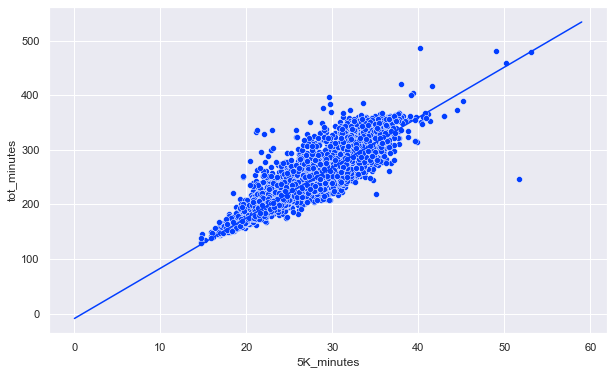

In [35]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_df, x='5K_minutes', y='tot_minutes', marker='o')
x = np.arange(0, 60)
plt.plot(x, reg.coef_[0]*x + reg.intercept_, c='b');

In [36]:
train_df['regression'] = reg.predict(train_df[['5K_minutes']])

In [37]:
num = 0
den = len(train_df) 
for i in tqdm(range(den)):
    if train_df.iloc[i,17] == train_df.iloc[i,19]:
        num += 1
print(num/den)

100%|█████████████████████████████████████████████████████████████████████████| 13149/13149 [00:00<00:00, 28353.00it/s]

0.0


In the case of Linear Regression, you cannot calculate the accuracy of the output just by comparing it to the actual. This works by just guessing what it would be so the way I got around that is instead of checking if its right and getting 0%  right, plot the difference in the finishing times and see the difference.

<AxesSubplot:xlabel='5K_minutes'>

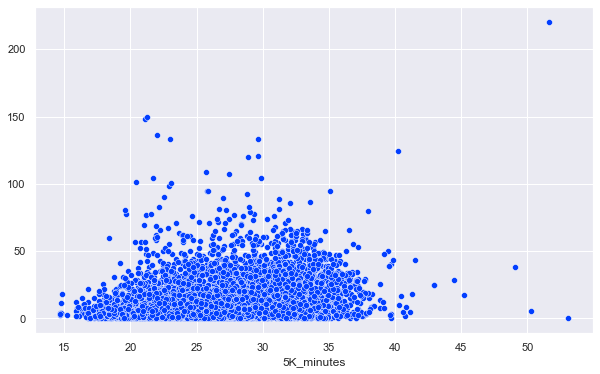

In [38]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_df['5K_minutes'], y=abs(train_df['tot_minutes']-train_df['regression']), marker='o')

In the graph above, the close the dot is to 0, the more accurate the prediciton was because it is looking at the difference from the actual runners time to the predicted finishing time. When there are more runners, it tends to be must less accurate.

In [39]:
reg2 = LinearRegression()
reg2.fit(train_df[['5K_minutes', 'Age']], train_df['tot_minutes'])

LinearRegression()

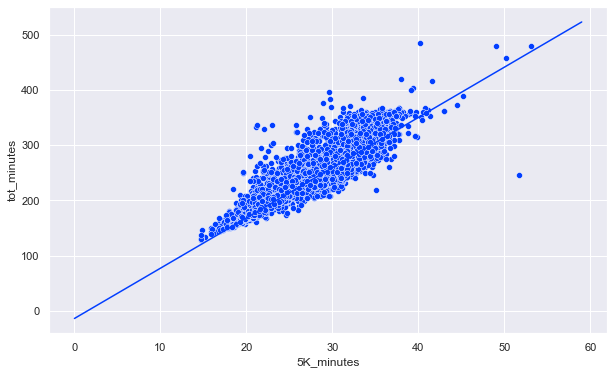

In [40]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_df, x='5K_minutes', y='tot_minutes', marker='o')
x = np.arange(0, 60)
plt.plot(x, reg2.coef_[0]*x + reg2.intercept_, c='b');

In [41]:
train_df['regression2'] = reg2.predict(train_df[['5K_minutes','Age']])
train_df

,Age,M/F,Country,5K,10K,15K,20K,Half,25K,30K,...,40K,Finish,Pace,Overall,Gender,Division,tot_minutes,5K_minutes,regression,regression2
1024,33,M,USA,00:18:33,00:37:18,00:56:26,01:15:51,01:20:12,01:35:51,01:56:38,...,02:40:36,02:50:47,00:06:31,1026,985,825,170.783333,18.550000,161.884748,160.960276
14892,40,F,USA,00:26:44,00:53:34,01:20:44,01:47:42,01:53:30,02:14:47,02:42:09,...,03:34:16,03:45:06,00:08:36,14970,5196,914,225.100000,26.733333,237.183494,236.694496
13216,55,M,USA,00:25:14,00:49:51,01:14:52,01:41:52,01:47:19,02:07:11,02:33:40,...,03:27:57,03:39:35,00:08:23,13277,9100,653,219.583333,25.233333,223.381279,225.691834
10302,37,M,USA,00:26:17,00:50:37,01:15:09,01:40:43,01:46:17,02:07:12,02:33:12,...,03:21:09,03:30:35,00:08:02,10337,7833,3560,210.583333,26.283333,233.042829,232.067457
13164,57,M,USA,00:25:18,00:49:50,01:14:45,01:39:49,01:45:22,02:05:06,02:31:41,...,03:27:39,03:39:26,00:08:23,13224,9080,647,219.433333,25.300000,223.994711,226.652393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15377,26,F,USA,00:25:18,00:51:06,01:16:33,01:41:52,01:47:26,02:08:08,02:35:55,...,03:34:32,03:46:50,00:08:40,15463,5505,3578,226.833333,25.300000,223.994711,221.170598
21602,60,F,CAN,00:31:03,01:01:33,01:30:58,02:00:14,02:06:34,02:30:29,03:02:19,...,04:05:01,04:19:26,00:09:54,21787,9327,114,259.433333,31.050000,276.903199,279.527607
17730,43,F,USA,00:27:06,00:53:30,01:20:51,01:48:06,01:54:00,02:16:06,02:44:59,...,03:42:59,03:55:26,00:08:59,17852,6994,1297,235.433333,27.100000,240.557368,240.562916
15725,47,F,USA,00:27:22,00:53:47,01:19:38,01:47:14,01:53:03,02:13:46,02:41:02,...,03:36:21,03:48:11,00:08:43,15818,5737,649,228.183333,27.366667,243.011095,243.697826


<AxesSubplot:xlabel='5K_minutes'>

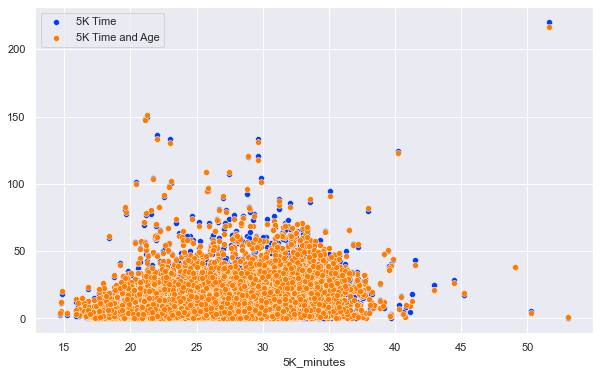

In [42]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_df['5K_minutes'], y=abs(train_df['tot_minutes']-train_df['regression']), marker='o',label='5K Time')
sns.scatterplot(x=train_df['5K_minutes'], y=abs(train_df['tot_minutes']-train_df['regression2']), marker='o',label='5K Time and Age')

When looking at the difference in times when inputting just the 5k time vs the 5k time and the ages you can see there is not actually that much of a difference. Because they are different colors you can tell tha the 2n2 regression model is a little bit tighter but it seems almost insignificant to me.

# Conclucions

Sorry this was a chaotic week and I dont have time to fill out the conclutions section. I would like to quickly say that all the the classifiers works in a similar precision. You would think that Bayes would perform better because it takes population into account but from the data itThis project analyzed marathon data, focusing on split times to make predictions about runner characteristics and outcomes. Using $k$-Nearest Neighbor predictors, we estimated the likelihood of a runner's gender based on their split times, while linear regression allowed us to predict final marathon times using gender and 5K split times. Both methods provided valuable insights, with each offering strengths depending on the prediction goal.

The $k$-Nearest Neighbor approach worked well for classification tasks, like predicting gender, leveraging patterns in the data effectively. On the other hand, linear regression proved ideal for estimating final times, showing strong correlations between early split times and overall performance. While both methods performed well, refining the models with additional features, like age or pacing strategy, could improve their accuracy further.

One interesting challenge was variability in pacing, as some runners displayed significant speed fluctuations that influenced prediction accuracy. Future work could explore incorporating pacing trends or using ensemble models to combine the strengths of $k$-NN and linear regression. Overall, this analysis highlighted the potential of machine learning tools to uncover meaningful patterns in marathon data and make actionable predictions. looks like kNN out performs it. 

## Bibliography/References

* Gandhi, R. (2018, May 17). Naive Bayes classifier. Medium. Retrieved April 23, 2023, from https://towardsdatascience.com/naive-bayes-classifier-81d512f50a7c 
* Al-Masri, Anas. “How Does Linear Regression Actually Work?” Medium, Towards Data Science, 3 Aug. 2021, towardsdatascience.com/how-does-linear-regression-actually-work-3297021970dd. Accessed 14 May 2023. 